## Load MNIST WAE model

In [1]:
import os, sys, time, logging
sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES']='5'
from SAE.dataset import labeled_MNIST, MNIST
from SAE.dataset import CelebA
from SAE.SAE import WAE_MMD_abstract
from SAE.util import init_params, gaus, multinomial, calculate_sharpness
import SAE.fid as fid

import torch
import torch.nn as nn
import torch.optim as optim
from exp_lmnist.cwae_1.train import CWAE_MMD_MNIST

import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

data_home = '/home/reddragon/data/MNIST'
train_data = labeled_MNIST(data_home, train = True)
test_data = labeled_MNIST(data_home, train = False)
test_data2 = MNIST(data_home, train = False, output_channels = 3) # to calculate FID

log = None
# logger = logging_daily('./exp_mnist/config/log_info.yaml')
# log = logger.get_logging()
# log.setLevel(logging.INFO)

In [3]:
network_info = {
    'train':{
        'z_sampler':gaus,
        'y_sampler':multinomial,
        'train_data':train_data,
        'test_data':test_data,
        'batch_size':100,
        'z_dim':6,
        'y_dim':10,

        'encoder_pretrain':False,
        'encoder_pretrain_batch_size':1000,
        'encoder_pretrain_max_step':200,

        'lr':5e-4,
        'beta1':0.9,
        'lambda':10.0,

        'lr_schedule':"manual",
        'validate':True,
        'histogram':True,

        'epoch':100,
        'iter_per_epoch':None,
    },
    'path':{
        'save_best':False,
        'save_path':'./weight.pt',
        'tb_logs':'../tb_logs/cwae-1'
    }
}

cwae_MMD = CWAE_MMD_MNIST(network_info, log, device = device, verbose = 0)
cwae_MMD.load('exp_lmnist/cwae_1/weight.pt')

### Reconstruction from test set

In [6]:
test_generator = torch.utils.data.DataLoader(test_data, 16, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample_image, test_sample_label = next(iter(test_generator))
recon_sample = cwae_MMD(test_sample_image.to(device), test_sample_label.to(device),).to('cpu').detach().numpy()

In [7]:
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

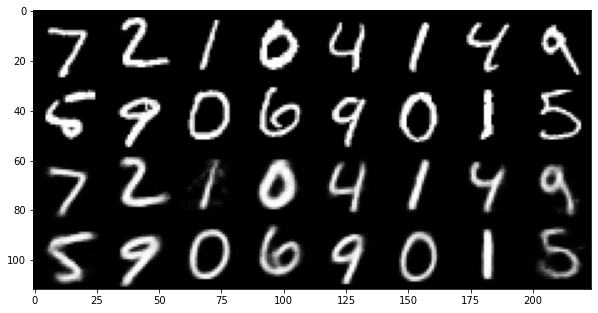

In [8]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Generation from prior distribution

In [9]:
test_z = []
test_label = []
z = gaus(6, 6)

for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)

In [10]:
gen_sample = cwae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(10):
    gz.append(np.concatenate([gen_sample[6*i + j,0,:,:] for j in range(6)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

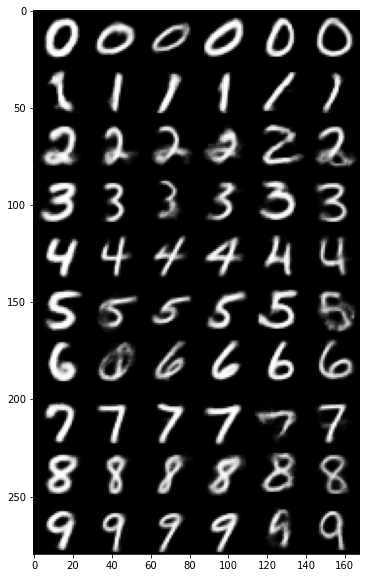

In [11]:
plt.figure(figsize = (6.0, 10.0))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

## Sharpness and FID

In [3]:
ss = calculate_sharpness(test_data2, device = device)
ss

array([0.59154326, 0.74747705, 0.38379332, ..., 0.63254058, 0.64670199,
       0.88449651])

In [5]:
ss.mean()

0.730941646450758

In [7]:
z_sampler = lambda x : torch.cat([gaus(x,6), multinomial(x,10)], dim = 1).to(device)

In [11]:
fid_model = fid.InceptionV3().to(device)

In [20]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device = device)

100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


In [17]:
act = fid.get_activations_generator(cwae_MMD.dec, z_sampler, fid_model, batch_size=100, repeat = 10, dims=2048, device=device)
m2 = np.mean(act,axis = 0)
s2 = np.cov(act, rowvar=False)

In [21]:
fid.calculate_frechet_distance(m1, s1, m2, s2)

37.70219384589018

In [19]:
test_z = []
test_label = []
z = gaus(6, 6)

for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)

In [19]:
gen_sample = cwae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(10):
    gz.append(np.concatenate([gen_sample[6*i + j,0,:,:] for j in range(6)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

tensor([[[[ 1.1516,  0.8245],
          [-2.5164,  0.6532]],

         [[ 1.1516,  0.8245],
          [-2.5164,  0.6532]],

         [[ 1.1516,  0.8245],
          [-2.5164,  0.6532]]],


        [[[ 0.0661, -1.1984],
          [ 0.8407,  1.4361]],

         [[ 0.0661, -1.1984],
          [ 0.8407,  1.4361]],

         [[ 0.0661, -1.1984],
          [ 0.8407,  1.4361]]]])

In [72]:
t1.var(axis = (1,2,3)).mean()

0.71344054

In [50]:
lap = lap_filter()
lap(torch.from_numpy(gen_sample)).shape
# lap.filter

torch.Size([99, 1, 26, 26])

In [39]:
torch.tensor([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]]).unsqueeze(0).unsqueeze(0)

tensor([[[[ 0., -1.,  0.],
          [-1.,  4., -1.],
          [ 0., -1.,  0.]]]])

In [ ]:
self.linear1.weight = torch.nn.Parameter(torch.zeros(D_in,H))

## Interploation between labels

In [14]:
int_label = []
for i in range(9):
    i_to_j = np.zeros((11, 10))
    for j in range(11):
        i_to_j[j, i] = 1 - 0.1*j
        i_to_j[j, i+1] = 0.1*j
    int_label.append(i_to_j)
int_labels = np.concatenate(int_label, axis = 0).astype(np.float32)

In [15]:
z_label = torch.from_numpy(int_labels)
z_latent = torch.zeros((99,6))
Z = torch.cat([z_latent, z_label], dim = 1).to(device)
Z.shape

torch.Size([99, 16])

In [16]:
gen_sample = cwae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(9):
    gz.append(np.concatenate([gen_sample[11*i + j,0,:,:] for j in range(11)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

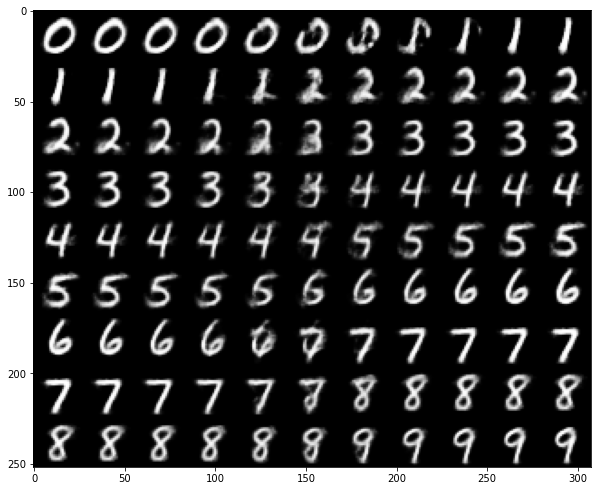

In [17]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

## Load CelebA WAE model

In [49]:
import os, sys, time, logging
sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES']='1'
from SAE.dataset import MNIST
from SAE.dataset import CelebA
from SAE.SAE import WAE_MMD_abstract
from SAE.util import init_params, gaus

import torch
import torch.nn as nn
import torch.optim as optim

from exp_celebA.train_base.train import WAE_MMD_celebA

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

data_home = '/home/reddragon/data/celebA'
train_data = CelebA(data_home, 'x_list_train.npy')
test_data = CelebA(data_home, 'x_list_test.npy')

log = None
# logger = logging_daily('./exp_mnist/config/log_info.yaml')
# log = logger.get_logging()
# log.setLevel(logging.INFO)

In [50]:
network_info = {
    'train':{
        'z_sampler':gaus,
        'train_data':train_data,
        'test_data':test_data,
        'batch_size':100,
        'z_dim':64,

        'encoder_pretrain':False,
        'encoder_pretrain_batch_size':1000,
        'encoder_pretrain_max_epoch':20,

        'lr':1e-3,
        'beta1':0.5,
        'lambda':100.0,

        'lr_schedule':"manual",
        'eps':1.0,
        'L':40,
        'validate':True,
        'histogram':True,

        'epoch':55,
        'iter_per_epoch':None,
    },
    'path':{
        'save_best':False,
        'save_path':'./weight.pt',
        'tb_logs':'../tb_logs/wae_celebA-base'
    }
}

wae_MMD = WAE_MMD_celebA(network_info, log, device = device, verbose = 0)
wae_MMD.load('exp_celebA/train_base/weight.pt')

### Reconstruction from test set

In [51]:
test_generator = torch.utils.data.DataLoader(test_data, 32, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample = next(iter(test_generator))
recon_sample = wae_MMD(test_sample.to(device)).to('cpu').detach().numpy()

In [65]:
test_sample = np.array(test_sample)
ghx = []
for i in range(4):
    ghx.append(np.concatenate([test_sample[8*i+j,:,:,:] for j in range(8)], axis = 2))
for i in range(4):
    ghx.append(np.concatenate([recon_sample[8*i+j,:,:,:] for j in range(8)], axis = 2))
recon_results = (np.concatenate(ghx, axis = 1) + 1)/2 # concatenate matrix for plt

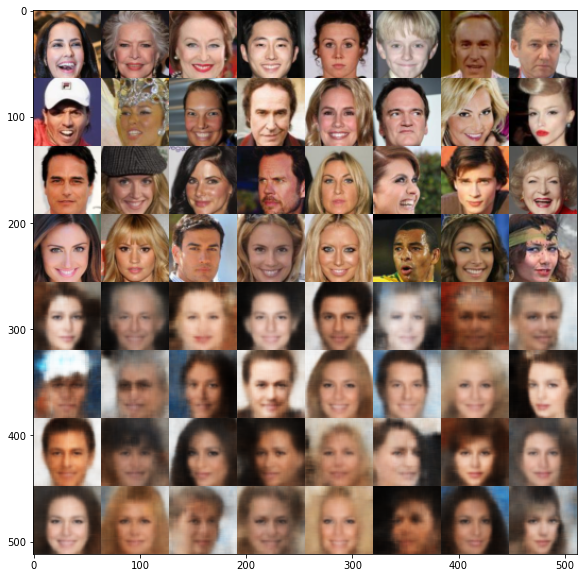

In [66]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results.transpose(1,2,0))
plt.show()

### Generation from prior distribution

In [72]:
Z = gaus(64, 64).to(device)
gen_sample = wae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(8):
    gz.append(np.concatenate([gen_sample[8*i + j,:,:,:] for j in range(8)], axis = 2))
generation_result = (np.concatenate(gz, axis = 1) + 1)/2 # concatenate matrix for plt

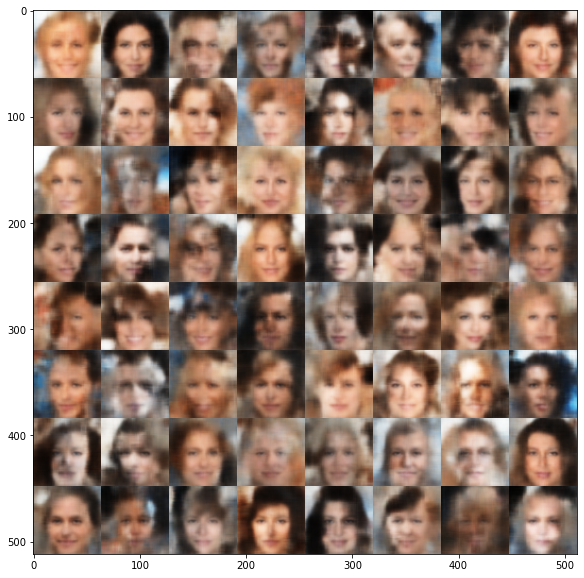

In [73]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(generation_result.transpose(1,2,0))
plt.show()

In [3]:
import torch
x = torch.ones((1,2,2))

In [4]:
dims = 2048
block_idx = fid.InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = fid.InceptionV3([block_idx]).to(device)
m, x = fid.calculate_activation_statistics(test_data2, model, batch_size=256, dims=2048, device=device, num_workers=8)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/reddragon/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


In [7]:
x.shape

(2048, 2048)

## Extended Yale B Face Data

* total number of people: 38
* total number of images: 2432
* image per person: at most 64

In [4]:
from SAE.dataset import eYaleB128
from exp_eYaleB.cwae_3.train import CWAE_MMD_eYaleB, multi_and_unif

In [14]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

data_home = '/home/reddragon/data/YaleBFace128'
train_data = eYaleB128(data_home, train = True)
test_data = eYaleB128(data_home, train = False)
test_data2 = eYaleB128(data_home, train = False, output_channels = 3)

log = None

In [10]:
network_info = {
    'train':{
        'z_sampler':gaus,
        'y_sampler':multi_and_unif,
        'train_data':train_data,
        'test_data':test_data,
        'batch_size':64,
        'z_dim':16,
        'y_dim':40,

        'encoder_pretrain':False,
        'encoder_pretrain_batch_size':1000,
        'encoder_pretrain_max_step':200,

        'lr':1e-3,
        'beta1':0.9,
        'lambda':10.0,

        'lr_schedule':"manual",
        'validate':True,
        'histogram':True,

        'epoch':100,
        'iter_per_epoch':None,
    },
    'path':{
        'save_best':False,
        'save_path':'./weight.pt',
        'tb_logs':'../tb_logs/cwae_3'
    }
}

cwae_MMD = CWAE_MMD_eYaleB(network_info, log, device = device, verbose = 0)
cwae_MMD.load('exp_eYaleB/cwae_3/weight.pt')

### Reconstruction from test set

In [11]:
test_generator = torch.utils.data.DataLoader(test_data, 16, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample_image, test_sample_label = next(iter(test_generator))
recon_sample = cwae_MMD(test_sample_image.to(device), test_sample_label.to(device),).to('cpu').detach().numpy()

In [12]:
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

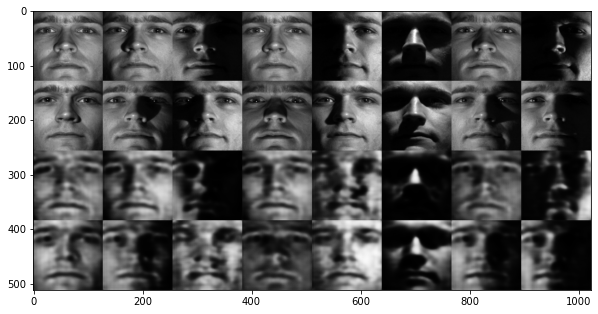

In [13]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Generation from prior distribution

In [56]:
test_z = []
test_label = []
test_lighting = []
z = torch.cat((torch.zeros(5, 16), gaus(5,16)), dim = 0)

for i in range(5):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(10,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)
test_lighting = torch.cat((torch.Tensor([[0.0, 0.0], [0.5, 0.3], [0.5, -0.3], [-0.5, 0.3], [-0.5, -0.3]]), torch.zeros(5, 2)), dim = 0).repeat(5,1)

Z = torch.cat([test_z, test_label, test_lighting], dim = 1).to(device)

In [57]:
Z.shape

torch.Size([50, 56])

In [60]:
gen_sample = cwae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(5):
    gz.append(np.concatenate([gen_sample[10*i + j,0,:,:] for j in range(10)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

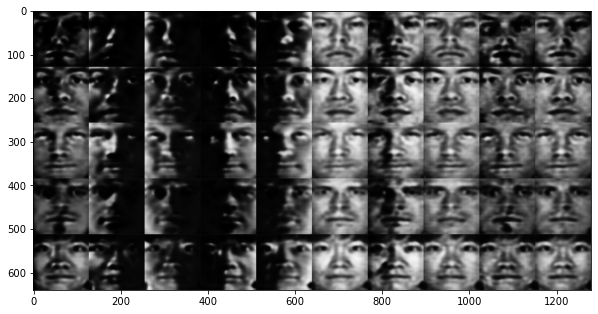

In [61]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

In [17]:
test_data2[0][0]

tensor([[[-0.5216, -0.4745, -0.4275,  ..., -0.4588, -0.4824, -0.4980],
         [-0.5059, -0.4588, -0.4275,  ..., -0.4431, -0.4745, -0.5059],
         [-0.4902, -0.4745, -0.4510,  ..., -0.4353, -0.4824, -0.5137],
         ...,
         [-0.6549, -0.6784, -0.6941,  ..., -0.4667, -0.5137, -0.5373],
         [-0.7255, -0.6863, -0.6784,  ..., -0.5216, -0.5137, -0.5373],
         [-0.7647, -0.7333, -0.6784,  ..., -0.5059, -0.5373, -0.5765]],

        [[-0.5216, -0.4745, -0.4275,  ..., -0.4588, -0.4824, -0.4980],
         [-0.5059, -0.4588, -0.4275,  ..., -0.4431, -0.4745, -0.5059],
         [-0.4902, -0.4745, -0.4510,  ..., -0.4353, -0.4824, -0.5137],
         ...,
         [-0.6549, -0.6784, -0.6941,  ..., -0.4667, -0.5137, -0.5373],
         [-0.7255, -0.6863, -0.6784,  ..., -0.5216, -0.5137, -0.5373],
         [-0.7647, -0.7333, -0.6784,  ..., -0.5059, -0.5373, -0.5765]],

        [[-0.5216, -0.4745, -0.4275,  ..., -0.4588, -0.4824, -0.4980],
         [-0.5059, -0.4588, -0.4275,  ..., -0

## Sharpness and FID

In [15]:
ss = calculate_sharpness(test_data2, device = device, labeled = True)
ss

AttributeError: 'list' object has no attribute 'shape'

In [5]:
ss.mean()

0.730941646450758

In [7]:
z_sampler = lambda x : torch.cat([gaus(x,6), multinomial(x,10)], dim = 1).to(device)

In [11]:
fid_model = fid.InceptionV3().to(device)

In [20]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device = device)

100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


In [17]:
act = fid.get_activations_generator(cwae_MMD.dec, z_sampler, fid_model, batch_size=100, repeat = 10, dims=2048, device=device)
m2 = np.mean(act,axis = 0)
s2 = np.cov(act, rowvar=False)

In [21]:
fid.calculate_frechet_distance(m1, s1, m2, s2)

37.70219384589018